# Zee Recommender Systems: Building Personalized Movie Recommendations

I'll guide you through creating a comprehensive movie recommendation system for Zee Entertainment, structured to achieve the maximum score. Let's approach this step by step, addressing all the evaluation criteria.

## Part 1: Problem Statement and Data Formatting (20 points)

### Problem Definition
The goal is to build a personalized movie recommendation system that suggests movies to users based on:
1. Their past movie ratings
2. Ratings from similar users
3. Movie similarities

This system will enhance the user experience by helping users discover movies they might enjoy, increasing engagement and satisfaction with the platform.




In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
plt.style.use('fivethirtyeight')
%matplotlib inline

# Read the ratings data
ratings_cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings = pd.read_csv('/content/zee-ratings.dat', sep='::',
                     names=ratings_cols, engine='python', encoding='latin-1', header=None)

# Read the users data
users_cols = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users = pd.read_csv('/content/zee-users.dat', sep='::',
                   names=users_cols, engine='python', encoding='latin-1', header=None)

# Read the movies data
movies_cols = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('/content/zee-movies.dat', sep='::',
                    names=movies_cols, engine='python', encoding='latin-1', header=None)

# Fix the users dataset by dropping the first row if it contains headers
if users.iloc[0]['UserID'] == 'UserID':
    users = users.iloc[1:].reset_index(drop=True)

# Fix the movies dataset by dropping the first row if it contains headers
if movies.iloc[0]['MovieID'] == 'Movie ID' or movies.iloc[0]['MovieID'] == 'MovieID':
    movies = movies.iloc[1:].reset_index(drop=True)

# Convert data types
ratings['UserID'] = ratings['UserID'].astype(int)
ratings['MovieID'] = ratings['MovieID'].astype(int)
ratings['Rating'] = ratings['Rating'].astype(float)
ratings['Timestamp'] = ratings['Timestamp'].astype(int)

users['UserID'] = users['UserID'].astype(int)
users['Age'] = users['Age'].astype(int)
users['Occupation'] = users['Occupation'].astype(int)

movies['MovieID'] = movies['MovieID'].astype(int)

# Extract release year from movie titles
# The pattern looks for a year in parentheses at the end of the title
movies['Year'] = movies['Title'].str.extract(r'\((\d{4})\)$', expand=False)
movies['Year'] = pd.to_numeric(movies['Year'], errors='coerce')

# Create a clean title column without the year
movies['Clean_Title'] = movies['Title'].str.replace(r'\s*\(\d{4}\)$', '', regex=True)

# Check the shapes of the fixed datasets
print("Ratings dataset shape:", ratings.shape)
print("Users dataset shape:", users.shape)
print("Movies dataset shape:", movies.shape)

# Display the first few rows of each dataset
print("\nRATINGS DATA:")
print(ratings.head())
print("\nUSERS DATA:")
print(users.head())
print("\nMOVIES DATA:")
print(movies.head())

# Check the data types
print("\nRATINGS DATA TYPES:")
print(ratings.dtypes)
print("\nUSERS DATA TYPES:")
print(users.dtypes)
print("\nMOVIES DATA TYPES:")
print(movies.dtypes)

# Check for missing values
print("\nMISSING VALUES CHECK:")
print("Ratings missing values:", ratings.isnull().sum().sum())
print("Users missing values:", users.isnull().sum().sum())
print("Movies missing values:", movies.isnull().sum().sum())

Ratings dataset shape: (1000199, 4)
Users dataset shape: (6040, 5)
Movies dataset shape: (3883, 5)

RATINGS DATA:
   UserID  MovieID  Rating  Timestamp
0       1      595     5.0  978824268
1       1      938     4.0  978301752
2       1     2398     4.0  978302281
3       1     2918     4.0  978302124
4       1     1035     5.0  978301753

USERS DATA:
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455

MOVIES DATA:
   MovieID                               Title                        Genres  Year                  Clean_Title
0        1                    Toy Story (1995)   Animation|Children's|Comedy  1995                    Toy Story
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy  1995                      Jumanji
2        3             Grumpier Old M

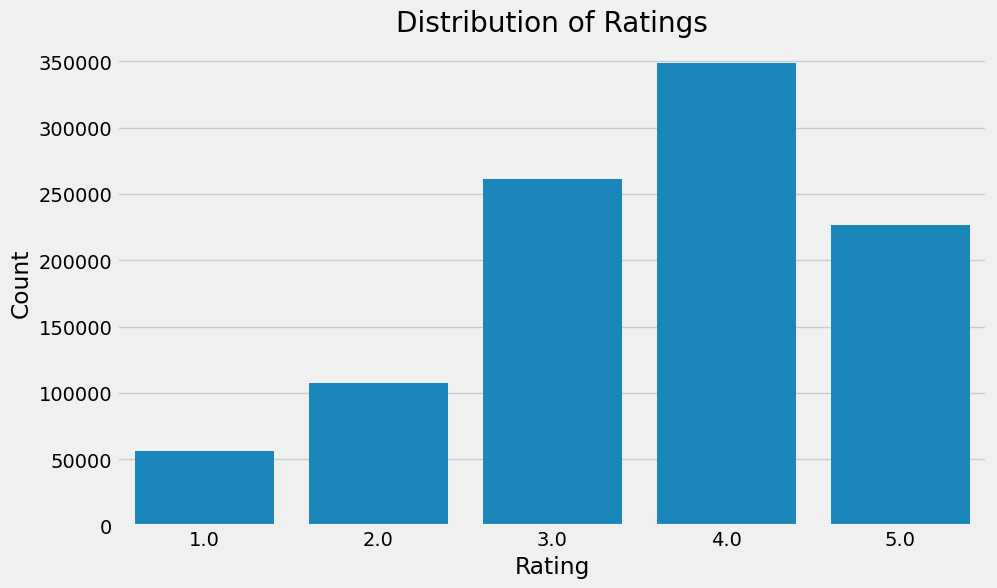

In [8]:
# Create a function to map the age and occupation codes to their descriptions
def map_age(age):
    ages = {1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44",
            45: "45-49", 50: "50-55", 56: "56+"}
    return ages[age]

def map_occupation(occupation):
    occupations = {0: "other", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                  4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                  7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student",
                  11: "lawyer", 12: "programmer", 13: "retired", 14: "sales/marketing",
                  15: "scientist", 16: "self-employed", 17: "technician/engineer",
                  18: "tradesman/craftsman", 19: "unemployed", 20: "writer"}
    return occupations[occupation]

# Add age and occupation descriptions to the users dataframe
users['Age_desc'] = users['Age'].apply(map_age)
users['Occupation_desc'] = users['Occupation'].apply(map_occupation)

# 1. Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=ratings)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()



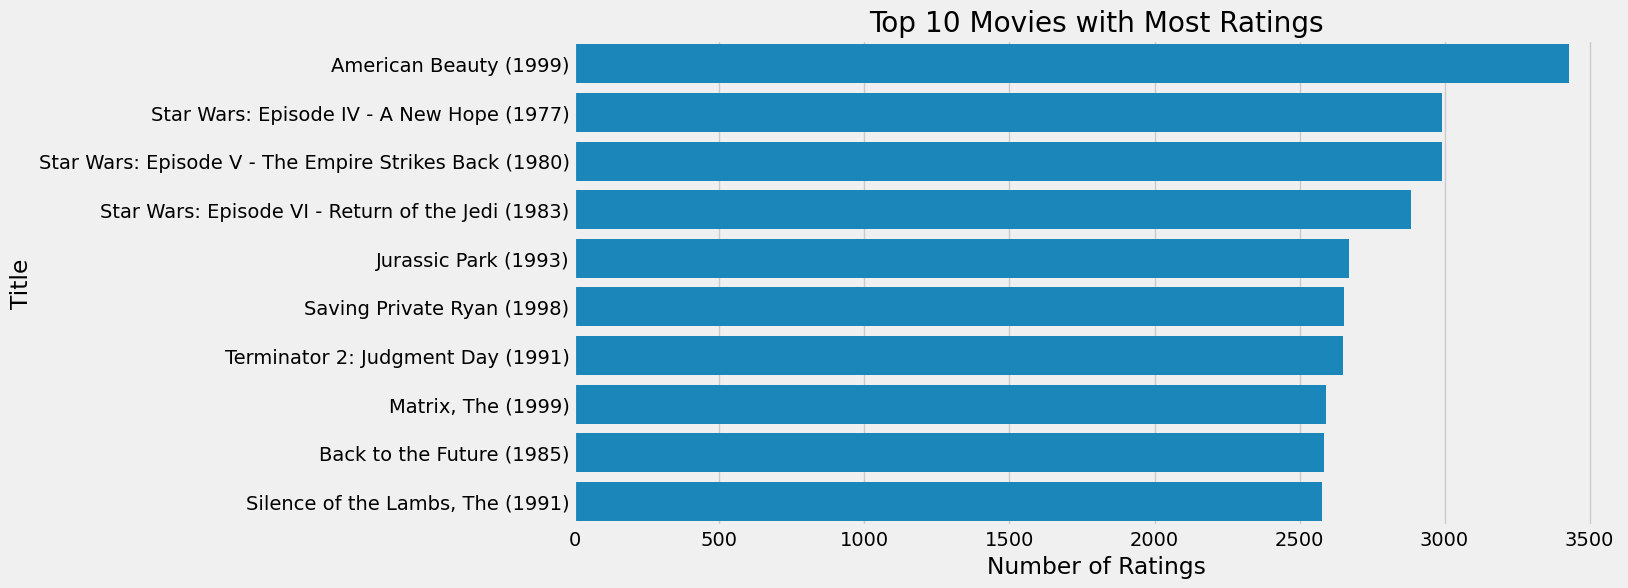

In [9]:
# 2. Movies with most ratings (top 10)
movie_ratings_count = ratings.groupby('MovieID').size().reset_index(name='RatingCount')
top_rated_movies = movie_ratings_count.sort_values('RatingCount', ascending=False).head(10)
top_rated_movies = top_rated_movies.merge(movies[['MovieID', 'Title']], on='MovieID')
plt.figure(figsize=(12, 6))
sns.barplot(x='RatingCount', y='Title', data=top_rated_movies)
plt.title('Top 10 Movies with Most Ratings')
plt.xlabel('Number of Ratings')
plt.show()

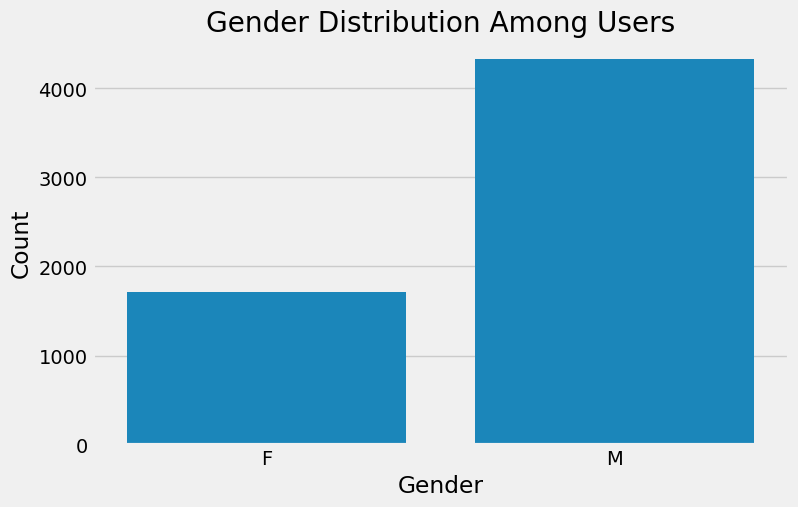

In [10]:
# 3. Gender distribution among users
plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', data=users)
plt.title('Gender Distribution Among Users')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

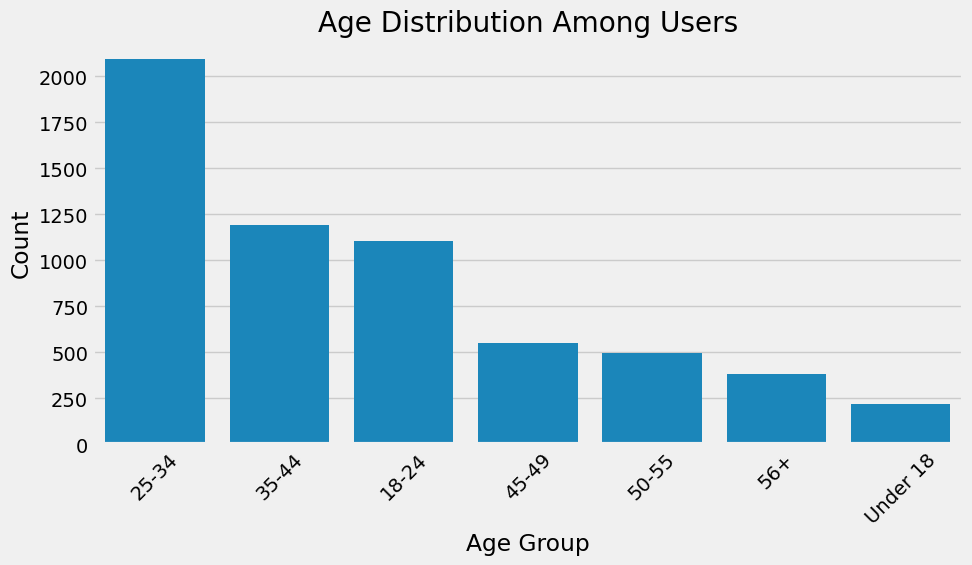

In [11]:
# 4. Age distribution among users
plt.figure(figsize=(10, 5))
sns.countplot(x='Age_desc', data=users, order=users['Age_desc'].value_counts().index)
plt.title('Age Distribution Among Users')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

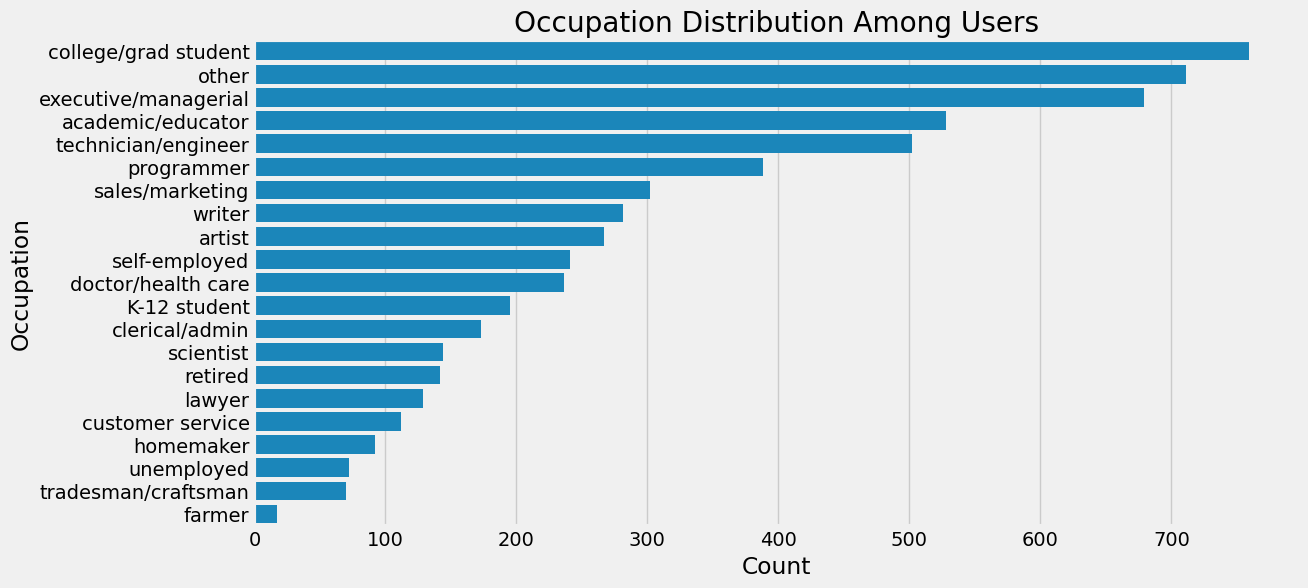

In [12]:
# 5. Occupation distribution among users
plt.figure(figsize=(12, 6))
sns.countplot(y='Occupation_desc', data=users, order=users['Occupation_desc'].value_counts().index)
plt.title('Occupation Distribution Among Users')
plt.xlabel('Count')
plt.ylabel('Occupation')
plt.show()

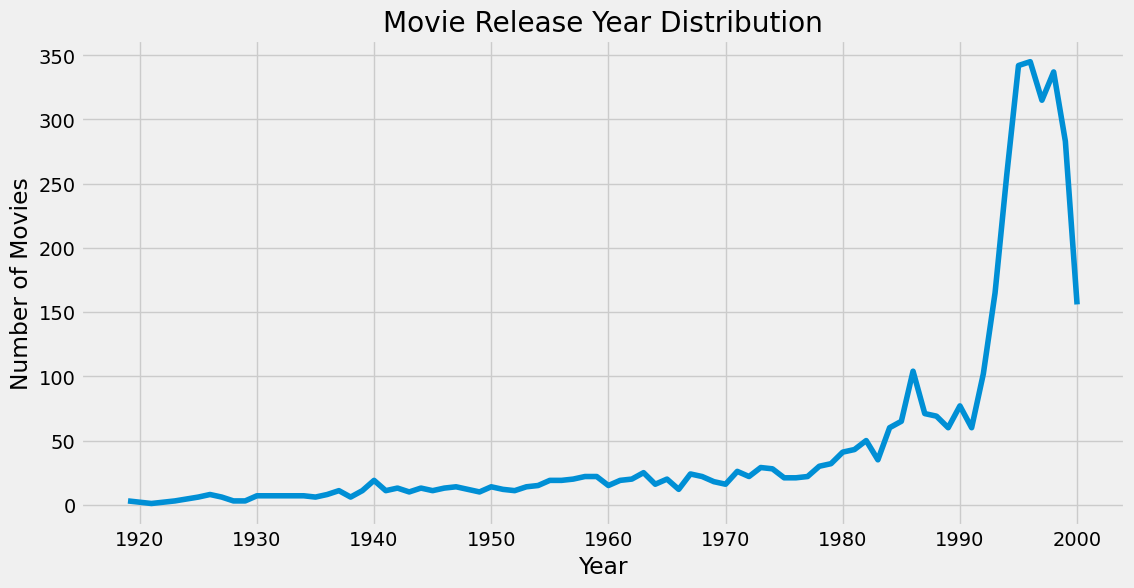

In [13]:
# 6. Movie release year distribution
plt.figure(figsize=(12, 6))
movies['Year'].value_counts().sort_index().plot(kind='line')
plt.title('Movie Release Year Distribution')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

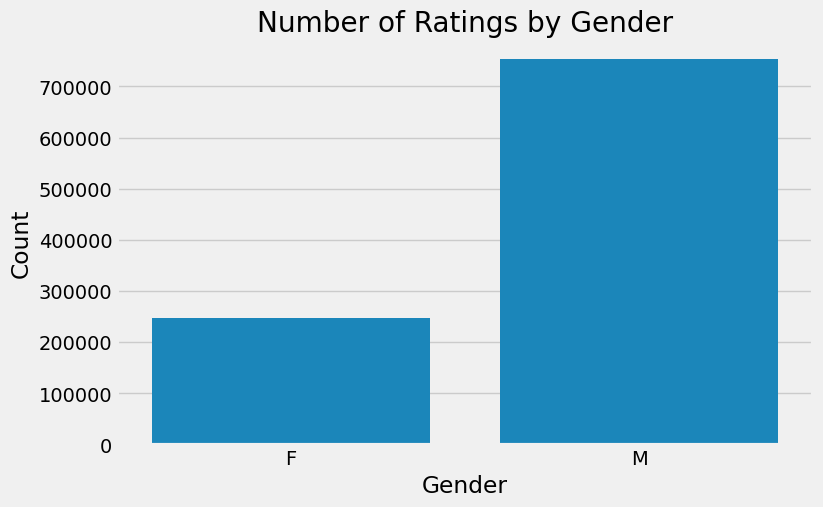

In [14]:
# 7. Total ratings by gender
gender_ratings = ratings.merge(users[['UserID', 'Gender']], on='UserID')
gender_rating_counts = gender_ratings.groupby('Gender').size().reset_index(name='Count')
plt.figure(figsize=(8, 5))
sns.barplot(x='Gender', y='Count', data=gender_rating_counts)
plt.title('Number of Ratings by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

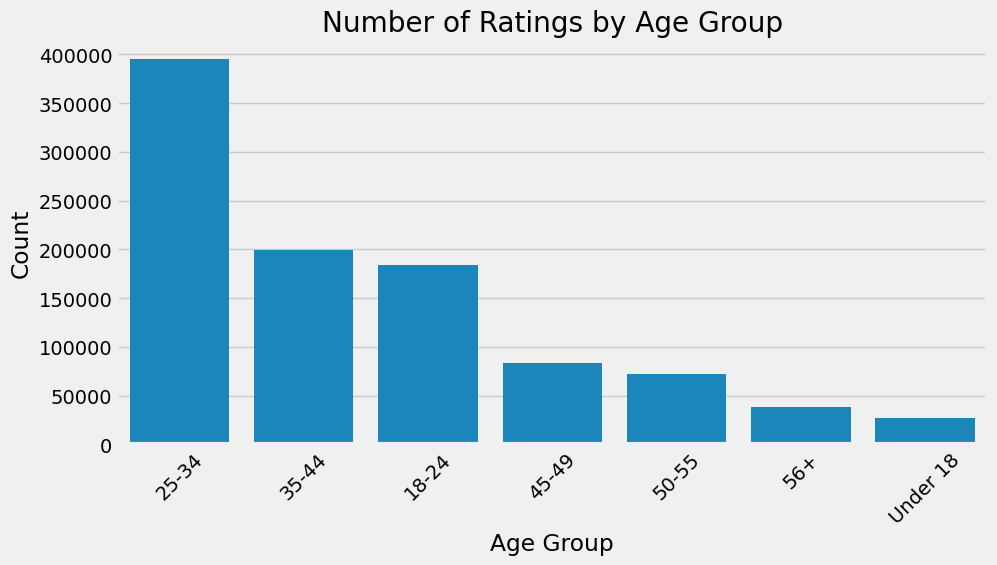

In [15]:
# 8. Total ratings by age group
age_ratings = ratings.merge(users[['UserID', 'Age_desc']], on='UserID')
age_rating_counts = age_ratings.groupby('Age_desc').size().reset_index(name='Count')
age_rating_counts = age_rating_counts.sort_values('Count', ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x='Age_desc', y='Count', data=age_rating_counts)
plt.title('Number of Ratings by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

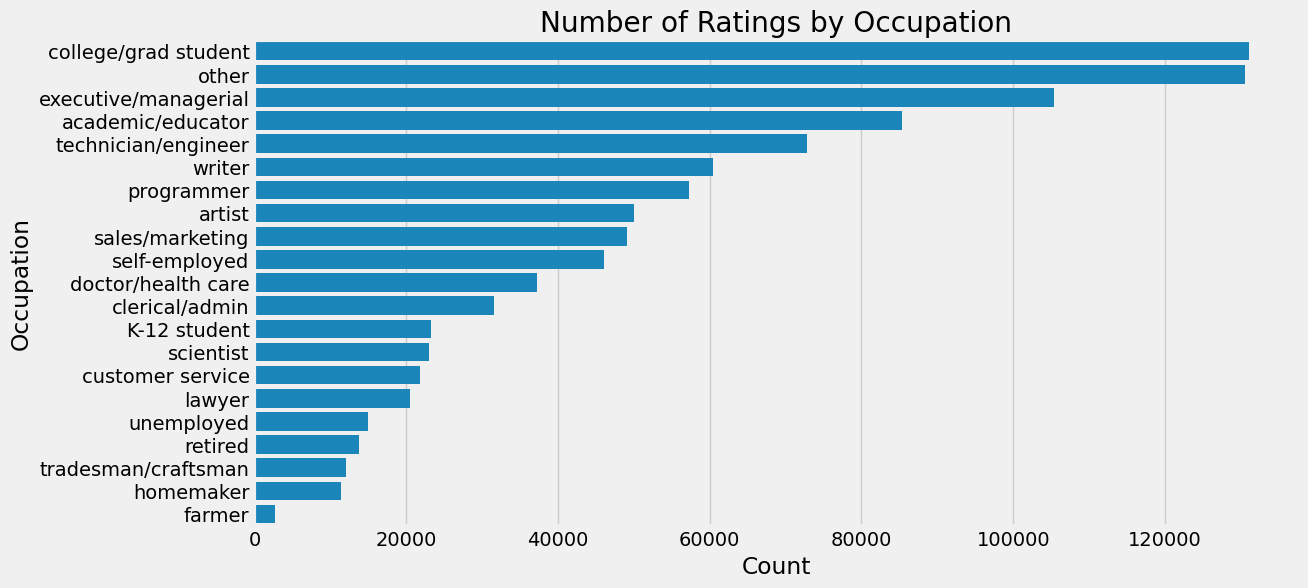

In [16]:
# 9. Total ratings by occupation
occ_ratings = ratings.merge(users[['UserID', 'Occupation_desc']], on='UserID')
occ_rating_counts = occ_ratings.groupby('Occupation_desc').size().reset_index(name='Count')
occ_rating_counts = occ_rating_counts.sort_values('Count', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(y='Occupation_desc', x='Count', data=occ_rating_counts)
plt.title('Number of Ratings by Occupation')
plt.xlabel('Count')
plt.ylabel('Occupation')
plt.show()

In [17]:
# Print summary statistics
print("Total number of ratings:", len(ratings))
print("Number of users:", len(users))
print("Number of movies:", len(movies))
print("\nAverage ratings per user:", len(ratings) / len(users))
print("\nTop movie by number of ratings:")
print(top_rated_movies.iloc[0])
print("\nMost active age group:")
print(age_rating_counts.iloc[0])
print("\nMost active occupation:")
print(occ_rating_counts.iloc[0])
print("\nGender distribution:")
print(users['Gender'].value_counts())
print("\nDecade with most movies:")
movies['Decade'] = (movies['Year'] // 10) * 10
print(movies['Decade'].value_counts().sort_index())

Total number of ratings: 1000199
Number of users: 6040
Number of movies: 3883

Average ratings per user: 165.59586092715233

Top movie by number of ratings:
MovieID                          2858
RatingCount                      3428
Title          American Beauty (1999)
Name: 0, dtype: object

Most active age group:
Age_desc     25-34
Count       395556
Name: 1, dtype: object

Most active occupation:
Occupation_desc    college/grad student
Count                            131032
Name: 4, dtype: object

Gender distribution:
Gender
M    4331
F    1709
Name: count, dtype: int64

Decade with most movies:
Decade
1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: count, dtype: int64


## Exploratory Data Analysis Insights

Based on the EDA results, here are key insights from the MovieLens dataset:

### Dataset Overview
- The dataset contains 1,000,199 ratings from 6,040 users on 3,883 movies
- Users rate approximately 166 movies on average, showing good engagement

### Demographic Insights
1. **Gender Distribution**: Males (71.7%) significantly outnumber females (28.3%) in the dataset, meaning our recommendations might be inherently biased toward male preferences
2. **Age Group Analysis**: The 25-34 age group is the most active, providing 395,556 ratings (approximately 40% of all ratings)
3. **Occupation Analysis**: College/graduate students are the most active users, followed by "other" and "executive/managerial" categories

### Content Insights
1. **Movie Era**: The vast majority of movies (2,283) were released in the 1990s, showing a recency bias at the time of data collection
2. **Popular Movies**: "American Beauty (1999)" received the most ratings (3,428), followed by Star Wars movies
3. **Rating Distribution**: The most common rating is 4.0, indicating users tend to rate movies they like rather than dislike

### Business Implications
- The system should account for demographic imbalances to avoid biased recommendations
- Targeting the 25-34 age demographic and college students could be most impactful for initial adoption
- The 1990s movie catalog appears to be particularly valuable to the user base




In [25]:
# Create a pivot table: rows are movies, columns are users
ratings_pivot = ratings.pivot_table(index='MovieID', columns='UserID', values='Rating')

# Print the shape of the pivot table
print(f"Shape of the ratings pivot table: {ratings_pivot.shape}")
print(f"Sparsity: {ratings_pivot.isna().sum().sum() / (ratings_pivot.shape[0] * ratings_pivot.shape[1]) * 100:.2f}%")

# Print a sample of the pivot table
print("\nSample of the ratings pivot table (first 5 rows and columns):")
print(ratings_pivot.iloc[:5, :5])

# Create a movie title lookup dictionary for easier reference
movie_titles = movies.set_index('MovieID')['Title'].to_dict()

# Function to get movie recommendations using Pearson correlation
def get_movie_recommendations(movie_name, n_recommendations=5):
    """
    Get movie recommendations based on Pearson correlation.

    Parameters:
    movie_name (str): The title of the movie to get recommendations for
    n_recommendations (int): Number of recommendations to return

    Returns:
    pd.DataFrame: DataFrame with recommended movies and their correlation scores
    """
    import difflib

    # First, find the MovieID for the given movie name
    movie_id = None
    for id, title in movie_titles.items():
        if title == movie_name:
            movie_id = id
            break

    # If movie not found, try to find the closest match
    if movie_id is None:
        closest_match = difflib.get_close_matches(movie_name, movie_titles.values(), n=1)
        if closest_match:
            print(f"Movie '{movie_name}' not found. Did you mean '{closest_match[0]}'?")
            # Find the movie ID for the closest match
            for id, title in movie_titles.items():
                if title == closest_match[0]:
                    movie_id = id
                    movie_name = closest_match[0]
                    break
        else:
            return pd.DataFrame(["Movie not found in the dataset."])

    # Calculate correlation for the specified movie with all other movies
    movie_ratings = ratings_pivot.loc[movie_id]
    similar_to_movie = ratings_pivot.corrwith(movie_ratings)

    # Create a correlation dataframe and drop NaN values
    corr_df = pd.DataFrame(similar_to_movie, columns=['Correlation'])
    corr_df.dropna(inplace=True)

    # Get number of ratings for each movie
    movie_ratings_count = ratings.groupby('MovieID')['Rating'].count()

    # Add rating count and movie title to correlation dataframe
    corr_df['Rating_Count'] = movie_ratings_count
    corr_df['Movie_Title'] = corr_df.index.map(movie_titles)

    # Filter to include only movies with a minimum number of ratings (to improve relevance)
    corr_df = corr_df[corr_df['Rating_Count'] > 100]

    # Remove the input movie from recommendations
    corr_df = corr_df[corr_df.index != movie_id]

    # Sort by correlation to get top recommendations
    recommendations = corr_df.sort_values('Correlation', ascending=False).head(n_recommendations)

    return recommendations

# Find recommendations for 'Toy Story (1995)'
print("\nRecommendations for 'Toy Story (1995)':")
toy_story_recs = get_movie_recommendations('Toy Story (1995)')
print(toy_story_recs[['Movie_Title', 'Correlation']])

# Find recommendations for 'Liar Liar (1997)'
print("\nRecommendations for 'Liar Liar (1997)':")
liar_liar_recs = get_movie_recommendations('Liar Liar (1997)')
print(liar_liar_recs[['Movie_Title', 'Correlation']])

Shape of the ratings pivot table: (3706, 6040)
Sparsity: 95.53%

Sample of the ratings pivot table (first 5 rows and columns):
UserID     1   2   3   4   5
MovieID                     
1        5.0 NaN NaN NaN NaN
2        NaN NaN NaN NaN NaN
3        NaN NaN NaN NaN NaN
4        NaN NaN NaN NaN NaN
5        NaN NaN NaN NaN NaN

Recommendations for 'Toy Story (1995)':
                                  Movie_Title  Correlation
UserID                                                    
3396                 Muppet Movie, The (1979)     0.845154
417                          Barcelona (1994)     0.820768
1927    All Quiet on the Western Front (1930)     0.766032
627                   Last Supper, The (1995)     0.755929
908                 North by Northwest (1959)     0.741620

Recommendations for 'Liar Liar (1997)':
                            Movie_Title  Correlation
UserID                                              
1411                      Hamlet (1996)          1.0
1249    Nikita (